In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import re
import itertools
import os
import pandas as pd
import numpy as np

In [2]:
def get_smali_paths(app_path): #create a list of smali file paths from app path
    smalis = []
    for d, dirs, files in os.walk(app_path + '/smali/'):
        for file in files:
            if file.endswith('smali'):
                smalis.append(os.path.join(d, file))
    return smalis

def get_smali_paths(app_path): #create a list of smali file paths from app path
    smalis = []
    for d, dirs, files in os.walk(app_path + '/smali/'):
        for file in files:
            if file.endswith('smali'):
                smalis.append(os.path.join(d, file))
    return smalis

def smalis_from_paths(paths): #create list of smali texts from list of paths
    return [open(p, 'r').read() for p in paths]

def find_blocks(smali):
    return re.findall( '\.method([\S\s]*?)\.end method', smali)

def find_apis(block):
    return re.findall('(invoke-.*?)\\n', block)

def invoke_type(api):
    return re.search('(invoke-\w+)(?:\/range)? {.*},', api)[1]

def package(api):
    return re.search('invoke-.*? {.*?}. (\[*[ZBSCFIJD]|\[*L[\w\/$-]+;)->', api)[1]

#different abstraction to reduce time of for loops below
def num_api(smalis):
    total = 0
    apis = []
    for smali in smalis:
        api = find_apis(smali)
        total += len(api)
        apis += api
    return total, len(set(apis)) #return total apis and unique apis
        
def num_method(smalis):
    total = 0
    blocks = []
    for smali in smalis:
        block = find_blocks(smali)
        total += len(block)
        blocks += block
    return total, len(set(blocks)) #return total methods and unique methods

def most_used_package(smalis):
    package = {}
    for smali in smalis:
        ps = re.findall('invoke-.*? {.*?}. (\[*[ZBSCFIJD]|\[*L[\w\/$-]+;)->', smali)
        for p in ps:
            if p in package.keys():
                package[p] += 1
            else:
                package[p] = 1
    try:
        most_used = max(package, key=package.get)
    except:
        most_used = np.nan
    return most_used #return mostly used package

def extract_simple_feat(apps):
    num_apis = []
    unique_apis = []
    num_methods = []
    unique_methods = []
    most_used_package = []
    for app in apps: #extract features
        smalis = etl.smalis_from_paths(etl.get_smali_paths('data/'+app))
        n, u = etl.num_api(smalis)
        num_apis.append(n)
        unique_apis.append(u)
        n, u = etl.num_method(smalis)
        num_methods.append(n)
        unique_methods.append(u)
        most_used_package.append(etl.most_used_package(smalis))
        
    df = pd.DataFrame({
        'apps':apps,
        'num_api':num_apis,
        'unique_api':unique_apis,
        'num_method':num_methods,
        'unique_method':unique_methods,
        'most_used_package':most_used_package,
        'malware': [0]*len(most_used_package)
    })
    return df[df['apps']!='.DS_Store']

#model training

def cat_package():
    cat_feat = ['most_used_package']
    cat_trans = Pipeline(steps=[
        ('onehot', OneHotEncoder())
        ])
    return ColumnTransformer(transformers=[('cat', cat_trans,cat_feat)])

def fn_LR(df_train, df_test, pre):
    X = df_train.drop('malware', 1)
    y = df_train.malware
    pipe = Pipeline(steps=[('preprocessor', pre),
                       ('clf', LogisticRegression())
                       ])
    pipe.fit(X,y)
    X_te = df_train.drop('malware', 1)
    y_te = df_train.malware
    y_pred = pipe.predict(X_te)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    return fn/(tn+fp+fn+tp)

def fn_RF(df_train, df_test, pre):
    X = df_train.drop('malware', 1)
    y = df_train.malware
    pipe = Pipeline(steps=[('preprocessor', pre),
                       ('clf', RandomForestClassifier(max_depth=2, random_state=0))
                       ])
    pipe.fit(X,y)
    X_te = df_train.drop('malware', 1)
    y_te = df_train.malware
    y_pred = pipe.predict(X_te)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    return fn/(tn+fp+fn+tp)

def fn_GBT(df_train, df_test, pre):
    X = df_train.drop('malware', 1)
    y = df_train.malware
    pipe = Pipeline(steps=[('preprocessor', pre),
                       ('clf', GradientBoostingClassifier())
                       ])
    pipe.fit(X,y)
    X_te = df_train.drop('malware', 1)
    y_te = df_train.malware
    y_pred = pipe.predict(X_te)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    return fn/(tn+fp+fn+tp)

### EDA

In [3]:
cats = os.listdir('data')

In [4]:
cats

['.DS_Store', 'education', 'dating']

In [5]:
num_apis = []
unique_apis = []
num_methods = []
unique_methods = []
most_used_packages = []

In [7]:
for app in os.listdir('data'+'/'+cats[1]): #extract features
    smalis = smalis_from_paths(get_smali_paths('data'+'/'+cats[1]+'/'+app))
    n, u = num_api(smalis)
    num_apis.append(n)
    unique_apis.append(u)
    n, u = num_method(smalis)
    num_methods.append(n)
    unique_methods.append(u)
    most_used_packages.append(most_used_package(smalis))

In [14]:
df = pd.DataFrame({
    'apps': os.listdir('data'+'/'+cats[1]),
    'num_api':num_apis,
    'unique_api':unique_apis,
    'num_method':num_methods,
    'unique_method':unique_methods,
    'most_used_package':most_used_packages,
    'dating': [0]*len(most_used_packages)
})
df = df[df['apps']!='.DS_Store']

In [15]:
df.shape

(20, 7)

In [16]:
df

,apps,num_api,unique_api,num_method,unique_method,most_used_package,dating
0,com.infinitecampus.mobilePortal,82396,36731,24599,23777,Ljava/lang/StringBuilder;,0
1,com.t11.skyviewfree,29712,15286,6852,6474,Ljava/lang/StringBuilder;,0
2,com.speaktribe.spanish,100028,42896,30829,29790,Ljava/lang/StringBuilder;,0
3,it.tinytap.market,171705,73449,53423,51295,Ljava/lang/StringBuilder;,0
4,com.wendy,159206,66661,50544,48806,Ljava/lang/StringBuilder;,0
5,com.quizlet.quizletandroid,0,0,0,0,NaN,0
6,com.gonliapps.learnspanish,140028,58519,38310,36625,Ljava/lang/StringBuilder;,0
7,example.matharithmetics,103596,35020,28056,26744,Ljava/lang/StringBuilder;,0
8,com.jaysquared.games.whereishd.releasefree,0,0,0,0,NaN,0
9,com.MathUnderground.MathSolver,212413,82215,51619,49918,Ljava/lang/StringBuilder;,0


In [17]:
df.describe()

,num_api,unique_api,num_method,unique_method,dating
count,20.000000,20.000000,20.000000,20.000000,20.0
mean,118194.900000,49206.150000,35045.300000,33576.700000,0.0
std,63472.612666,26716.591839,19000.806817,18246.063873,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,83831.500000,36303.250000,24246.500000,23369.000000,0.0
50%,130830.000000,50707.500000,37161.000000,34910.000000,0.0
75%,167326.250000,71864.250000,52082.750000,50006.000000,0.0
max,212413.000000,82215.000000,55186.000000,52702.000000,0.0


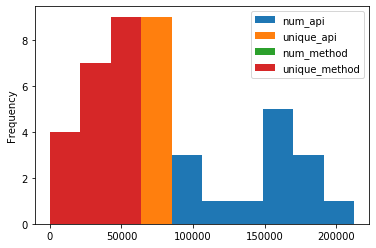

In [18]:
df.drop('dating',1).plot.hist()

In [19]:
df.most_used_package.value_counts()

Ljava/lang/StringBuilder;    15
Landroid/os/Parcel;           3
Name: most_used_package, dtype: int64

In [20]:
num_apis = []
unique_apis = []
num_methods = []
unique_methods = []
most_used_packages = []
num_apis = []
unique_apis = []
num_methods = []
unique_methods = []
most_used_packages = []
for app in os.listdir('data'+'/'+cats[2]): #extract features
    smalis = smalis_from_paths(get_smali_paths('data'+'/'+cats[2]+'/'+app))
    n, u = num_api(smalis)
    num_apis.append(n)
    unique_apis.append(u)
    n, u = num_method(smalis)
    num_methods.append(n)
    unique_methods.append(u)
    most_used_packages.append(most_used_package(smalis))


NameError: name 'dating' is not defined

In [22]:
df2 = pd.DataFrame({
    'apps': os.listdir('data'+'/'+cats[2]),
    'num_api':num_apis,
    'unique_api':unique_apis,
    'num_method':num_methods,
    'unique_method':unique_methods,
    'most_used_package':most_used_packages,
    'dating': [1]*len(most_used_packages)
})
df2 = df2[df2['apps']!='.DS_Store']

In [27]:
app_df = pd.concat([df, df2])

In [29]:
app_df.shape

(40, 7)

In [30]:
app_df.describe()

,num_api,unique_api,num_method,unique_method,dating
count,40.000000,40.000000,40.00000,40.000000,40.00000
mean,119750.300000,50280.775000,35214.22500,33490.050000,0.50000
std,74803.030882,31456.167384,21799.00646,20683.455878,0.50637
min,0.000000,0.000000,0.00000,0.000000,0.00000
25%,73283.750000,30396.000000,20844.25000,19880.000000,0.00000
50%,157718.000000,66267.000000,48318.50000,45875.500000,0.50000
75%,183769.750000,76246.750000,53435.00000,50763.250000,1.00000
max,212413.000000,85480.000000,58151.00000,53901.000000,1.00000


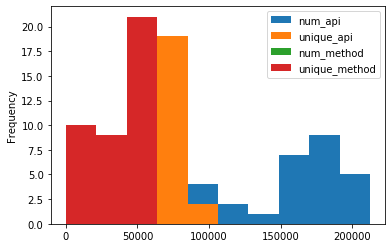

In [31]:
app_df.drop('dating',1).plot.hist()

In [32]:
app_df.most_used_package.value_counts()

Ljava/lang/StringBuilder;    29
Landroid/os/Parcel;           3
Name: most_used_package, dtype: int64

### train

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer


In [35]:
X = app_df.drop('dating', 1)
y = app_df.dating

In [49]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp2 = SimpleImputer(missing_values=np.NaN, strategy='mean')

cat_feat = ['most_used_package']
cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder())
    ])

imp_feat = X.columns.values
imp_trans = Pipeline(steps=[
    ('impute', imp2)
    ])

pre = ColumnTransformer(transformers=[('cat', cat_trans,cat_feat), ('imp', imp_trans,imp_feat)])

In [53]:
pipe = Pipeline(steps=[('preprocessor', pre),
                       ('clf', LogisticRegression())
                       ])
pipe.fit(X,y)

ValueError: Input contains NaN

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fn/()

In [27]:
clf = LogisticRegression().fit(X, y)
clf.predict()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'Ljava/lang/StringBuilder;'

### GRAPH

In [ ]:
G = nx.Graph()
api_id = {}
current_id = 0

G.add_node('helloworld', node_type = 'app')

smalis = smalis_from_paths(get_smali_paths('data/helloworld'))

nx.neighbors(G, 'helloworld')

A = nx.adjacency_matrix(G.nodes.node_type('api'))
print(A.todense()[0])

for smali in smalis:
    apis = find_apis(smali)
    for call in apis:
        if call not in G:
            G.add_node(call, node_type = 'api')
            G.add_edge('helloworld', call)

In [70]:
G = nx.Graph()

In [71]:
node_num = 0

In [72]:
blocks = re.findall( '\.method([\S\s]*?)\.end method', text)

In [73]:
for block in blocks:
    same_block = []
    for line in block.split('\n'):
        if re.search( '^(invoke\-.*)\)V', line.strip()):
            G.add_node(node_num)
            same_block.append(node_num)
            node_num += 1
            print(re.search( '^(invoke\-.*)\)V', line.strip()).group())
    for pair in itertools.product(same_block, repeat=2):
        G.add_edge(pair[0], pair[1])

invoke-direct {p0}, Landroid/support/v7/app/AppCompatActivity;-><init>()V
invoke-super {p0, p1}, Landroid/support/v7/app/AppCompatActivity;->onCreate(Landroid/os/Bundle;)V
invoke-virtual {p0, v0}, Lcom/ethicalhackx/myapplication/MainActivity;->setContentView(I)V


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


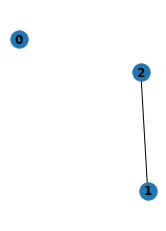

In [74]:
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')

In [31]:
nx.adjacency_matrix(G).todense()

matrix([[0., 0.],
        [0., 0.]])